In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime

In [4]:
# preamble for jupyter notebook and django
import django
import platform



if platform.node() == "mcc-apsis":
    sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

In [68]:
sns.set_style('whitegrid')

In [3]:
# update run_tm to show time
# data set: parliamentary discourse over all parliamentary periods
# find document size! 

In [9]:
user1, created =  User.objects.get_or_create(username='leey', email='lee@mcc-berlin.net')
user1.save()

In [10]:
# simple search for utterances
par_search_pdf_all, created = pm.Search.objects.get_or_create(
                title="Kohle pdf utterance all",
                text="kohle",
                creator=user1,
                document_source="from https.*scans of pdfs with xml metadata",
                search_object_type=2)
par_search_pdf_all.save()

if created:
    print("doing search")
do_search(par_search_pdf_all.id)
print(par_search_pdf_all.par_count)
print(par_search_pdf_all.utterance_count)
print(par_search_pdf_all.runstats_set.all())

8594 utterances with search kohle
108750
8594
108750
8594
<QuerySet [<RunStats: RunStats object (1156)>]>


### running dynamic topic models

In [11]:
K_list = [25,30,35,40,45,50,55,60]

In [13]:
for K in K_list:
    #run_tm.delay(par_search_pdf_all.id, K=K, method='BT')
    # instead of using delay (which sends to the default queue), we use the more 
    # verbose way to call the funtion (apply async) where we can specify that we
    # want to send it to the long queue, which only has two workers
    run_tm.apply_async(
        args=[par_search_pdf_all.id],
        kwargs={
            "K": K,
            "method": "BT"
        },
        queue="long"
    )
    # We don't need to sleep anymore, because we know they are being nicely scheduled
    #time.sleep(5)

### distribution of documents

In [65]:
# Truncating by month
utterances = pm.Utterance.objects.filter(search_matches=par_search_pdf_all)
graph_month = list(utterances.filter(document__date__isnull=False).order_by().annotate(
            year=TruncMonth('document__date')
        ).order_by('year').values('year').annotate(n = Count('id')))
count = utterances.count()

for i in range(len(graph_month)):
    graph_month[i]['year']=graph_month[i]['year'].strftime('%Y-%m')

In [78]:
month_list = []
for i in graph_month:
    month_list.append(sorted(i.items()))
    month_y, month_x = zip(*month_list)

In [85]:
mx = []
for i in month_x:
    mx.append(datetime.strptime(i[1], '%Y-%m'))
    
my = []
for i in month_y:
    my.append(i[1])

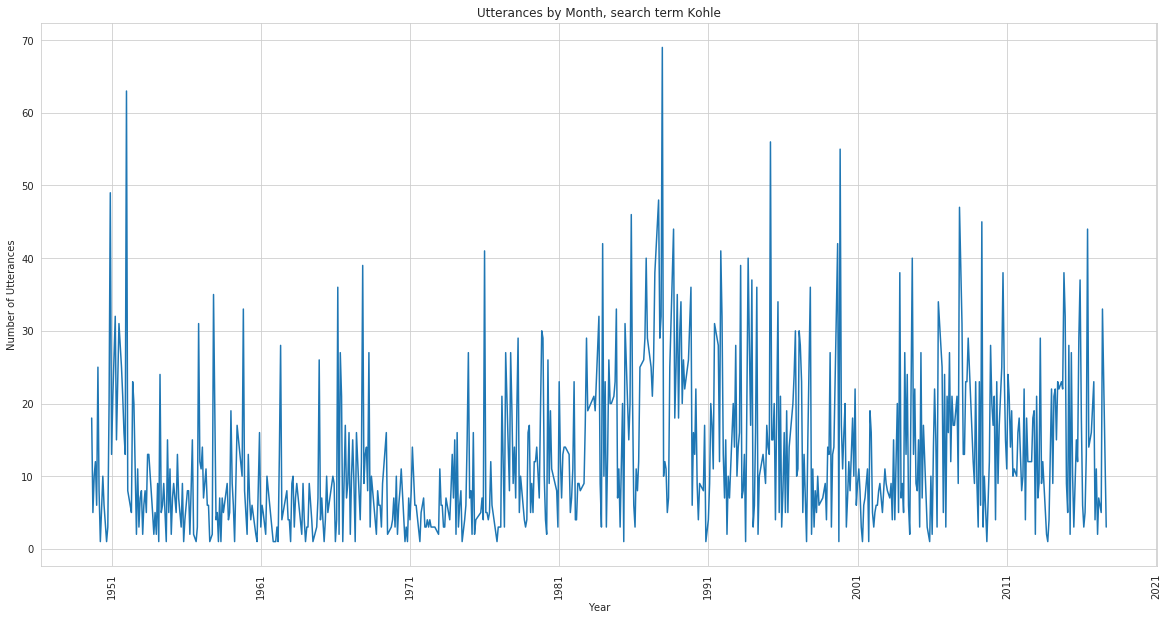

In [96]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(mx, my, ax = ax)

plt.xticks(rotation='vertical', fontsize=10)

ax.set(xlabel="Year",ylabel="Number of Utterances", title="Utterances by Month, search term Kohle")
plt.show()

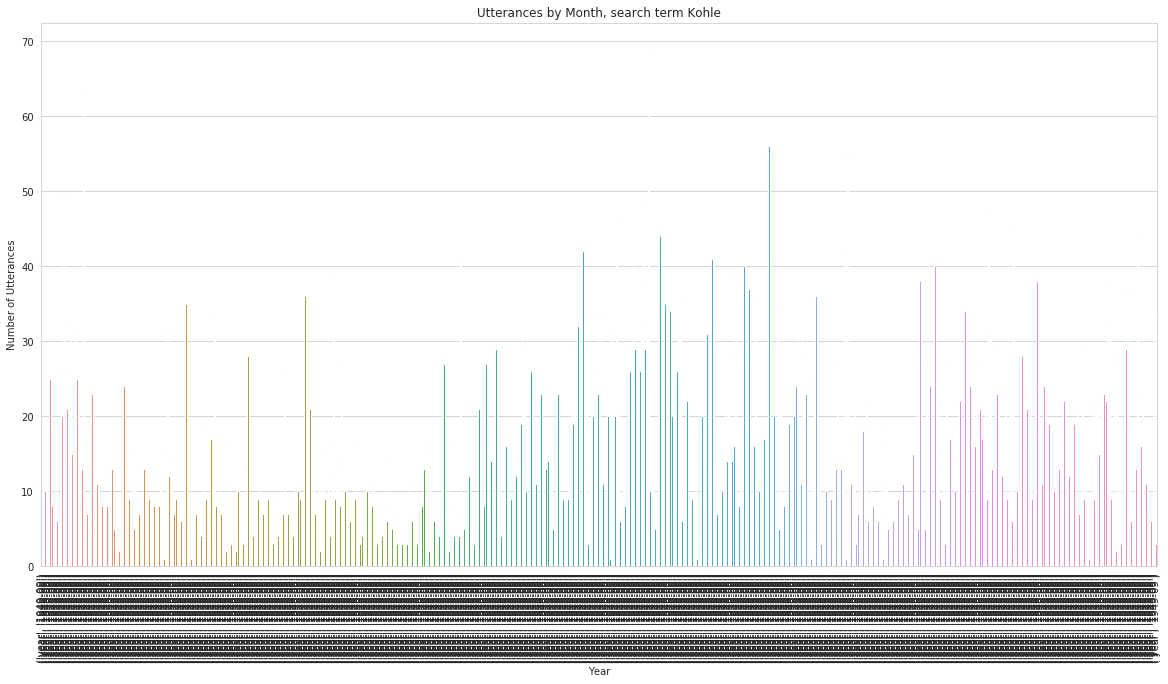

In [103]:
fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(mx, my, ax = ax)

plt.xticks(np.arange(len(mx)), [month_x[0] for i in month_x], rotation='vertical', fontsize=10)

ax.set(xlabel="Year",ylabel="Number of Utterances", title="Utterances by Month, search term Kohle")

plt.show()

In [66]:
# Truncating by year
graph_year = list(utterances.filter(document__date__isnull=False).order_by().annotate(
            year=TruncYear('document__date')
        ).order_by('year').values('year').annotate(n = Count('id')))
count = utterances.count()

for i in range(len(graph_year)):
    graph_year[i]['year']=graph_year[i]['year'].strftime('%Y')

In [43]:
year_list = []
for i in graph_year:
    year_list.append(sorted(i.items()))
    year_y, year_x = zip(*year_list)

In [76]:
yx = []
for i in year_x:
    yx.append(int(i[1]))
    
yy = []
for i in year_y:
    yy.append(i[1])
    

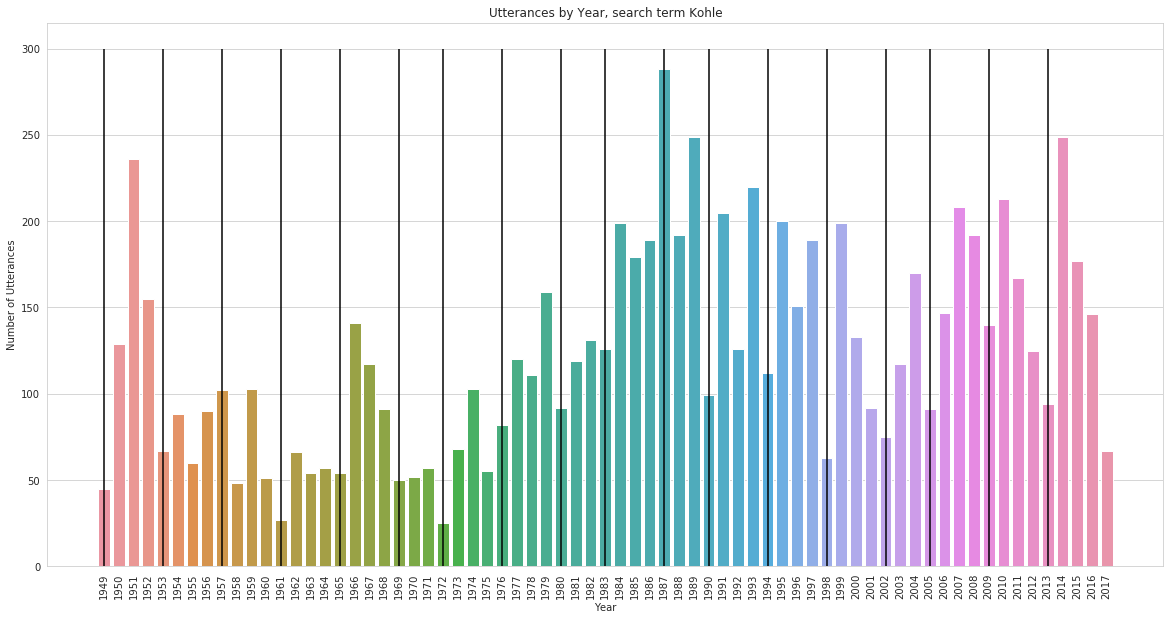

In [144]:
fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(yx, yy, ax = ax)

# add lines to show parliamentary periods
plt.vlines(0,0,300, label='Parliamentary Period {}'.format(pp_n[0]))
plt.vlines(4,0,300)
plt.vlines(8,0,300)
plt.vlines(12,0,300)
plt.vlines(16,0,300)
plt.vlines(20,0,300)
plt.vlines(23,0,300)
plt.vlines(27,0,300)
plt.vlines(31,0,300)
plt.vlines(34,0,300)
plt.vlines(38,0,300)
plt.vlines(41,0,300)
plt.vlines(45,0,300)
plt.vlines(49,0,300)
plt.vlines(53,0,300)
plt.vlines(56,0,300)
plt.vlines(60,0,300)
plt.vlines(64,0,300)

plt.xticks(rotation='vertical', fontsize=10)
ax.set(xlabel="Year",ylabel="Number of Utterances", title="Utterances by Year, search term Kohle")
plt.show()

In [112]:
# Getting parlperiods
pm.ParlPeriod.objects.filter() # don't have start dates 

<QuerySet [<ParlPeriod: Germany - National - 17>, <ParlPeriod: Germany - National - 18>, <ParlPeriod: Germany - National - 19>, <ParlPeriod: Germany - National - 16>, <ParlPeriod: Germany - National - 5>, <ParlPeriod: Germany - National - 6>, <ParlPeriod: Germany - National - 7>, <ParlPeriod: Germany - National - 8>, <ParlPeriod: Germany - National - 9>, <ParlPeriod: Germany - National - 10>, <ParlPeriod: Germany - National - 11>, <ParlPeriod: Germany - National - 3>, <ParlPeriod: Germany - National - 2>, <ParlPeriod: Germany - National - 4>, <ParlPeriod: Germany - National - 12>, <ParlPeriod: Germany - National - 13>, <ParlPeriod: Germany - National - 14>, <ParlPeriod: Germany - National - 15>, <ParlPeriod: Germany - National - 1>]>

In [122]:
# Bundestag by session, from Wikipedia
pp_n = np.arange(1,20,1)
pp_year = np.array([1949, 1953, 1957, 1961, 1965, 1969, 1972, 1976, 1980, 1983, 1987, 1990, 1994, 1998, 2002, 2005, 2009, 2013, 2017])

### Pickling

In [14]:
import pickle
pickle_out = open("dict.pickle","wb")
pickle.dump(graph, pickle_out)
pickle_out.close()

In [15]:
pickle_in = open("dict.pickle","rb")
example_dict = pickle.load(pickle_in)